**Certified Robustness Analysis**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os,shutil,json
import argparse
import copy
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportion_confint
import glob
import os
import copy
from scipy.special import comb
import numpy as np
parser = argparse.ArgumentParser()
parser.add_argument("-n1", type=int, default=375*1242) #number of basic elements in the first modality
parser.add_argument("-n2", type=int, default=375*1242) #number of basic elements in the second modality
parser.add_argument("-ablation_ratio_test", type=float, default=0.0107)#for randomized_ablation
parser.add_argument("-ablation_ratio_test1", type=float, default=0.0193)#for MMCert
parser.add_argument("-ablation_ratio_test2", type=float, default=0.00214)#for MMCert
parser.add_argument("-r2_geq_r1", type=float, default=True)#by default, r2>=r1
parser.add_argument("-r1_r2_ratio", type=int, default=2)#set to 1,2,3, or 4
parser.add_argument("-inverse_r1_r2_ratio", type=int, default=2)#set to 1,2,3, or 4 when r2_geq_r1 = False
parser.add_argument("-alpha", type=float, default=0.001)
parser.add_argument("-c", type=float, help="number of test samples", default=58)
parser.add_argument("-N", type=int, default=100) #number of ablated inputs for each test sample
parser.add_argument("-r_range", type=int, default=25) #attack strength range to consider for the experiment

def plot_tensor_image(tensor_image, batch_idx=0):
    # If tensor has more than 2 dimensions, select the batch index
    if len(tensor_image.shape) > 2:
        tensor_image = tensor_image[batch_idx]
    
    # Convert tensor to numpy array
    image_array = tensor_image.detach().cpu().numpy()

    # Plot the image
    plt.imshow(image_array, cmap='gray')
    plt.colorbar()
    plt.show()
def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
    """ Returns a (1 - alpha) lower confidence bound on a bernoulli proportion.
    This function uses the Clopper-Pearson method.
    :param NA: the number of "successes"
    :param N: the number of total draws
    :param alpha: the confidence level
    :return: a lower bound on the binomial proportion which holds true w.p at least (1 - alpha) over the samples
    """
    return proportion_confint(NA, N, alpha, method="beta")
    
def calculate_certified_metrics(all_gt, certified_pixels):
    """
    Calculate certified pixel accuracy, certified f1, and certified iou
    :param all_gt: ground truth pixel labels
    :param certified_pixels: represents certifiably robust pixels. 1 means certified, 0 means not certified.
    """
    # Ensure inputs are torch tensors
    all_gt = torch.tensor(all_gt)
    certified_pixels = torch.tensor(certified_pixels)

    # Calculate True Positives
    TP = torch.sum((all_gt == 1) & (certified_pixels == 1))

    # Calculate False Negative
    FN = torch.sum((all_gt == 1) & (certified_pixels == 0))
    # Calculate False Positive
    FP = torch.sum((all_gt == 0) & (certified_pixels == 0))
    # Calculate True Negative
    TN = torch.sum((all_gt == 0) & (certified_pixels == 1))
    # Handle the case where TP + FP = 0 to avoid division by zero

    # Calculate precision
    pixel_accuracy = (TP.float()+TN.float()) / (TP + FN+FP+TN).float()
    recall = TP.float() / (TP + FN).float()
    precision = TP.float() / (TP + FP).float()
    iou = TP.float() / (TP + FP+FN).float()
    if TP.float()<=0:
        f1 = torch.tensor(0)
    else:
        f1 = 2*TP.float()**2 / (2*TP.float()**2+TP.float()*(FP.float()+FN.float()))
    return round(pixel_accuracy.item(),4), round(recall.item(),4), round(f1.item(),4), round(iou.item(),4) # return as a scalar

def get_alpha_list(args,n1,n2,k1,k2,certification_method="MMCert"):
    """
    This function precomutes a certification confidence upper bound for (for all possible attack strength and all possible label frequency histogram).
    Later on, given an attack strength and a label frequency histogram, a confidence score can be returned using this list.
    """
    l =np.ones((args.r_range,args.N+1))
    
    for r in range(args.r_range): #r is the smaller value between r1 and r2. It represents the attack strength.
        if args.r2_geq_r1:
            r1 = r
            r2 = args.r1_r2_ratio*r
        else:
            r2 = r
            r1 = args.inverse_r1_r2_ratio*r
        e1 = n1-r1
        e2 = n2-r2
        if certification_method=="MMCert":
            delta = 1-((comb(e1,k1, exact=True)*comb(e2,k2, exact=True))/(comb(n1,k1, exact=True)*comb(n2,k2, exact=True)))
        else:
            delta = 1-((comb(e1+e2,k1+k2, exact=True))/(comb(n1+n2,k1+k2, exact=True)))
        for i in range(args.N+1):
            alpha = 0.00001 #initialize alpha to a large value (for a individual pixel)
            for j in range(50):
                lower_positive,upper_positive = _lower_confidence_bound(i, args.N, alpha)
                lower_negative,upper_negative = _lower_confidence_bound(args.N-i, args.N, alpha)
                if ((lower_positive-delta) > (upper_negative+delta)) or ((lower_negative-delta) > (upper_positive+delta)): #this means a pixel is certifiably stable with probability 1-current_alpha
                    alpha = alpha/10
                else:
                    if j ==0:
                        l[r][i]=1
                    else:
                        l[r][i]=alpha
                    break
    return l


def get_all_alpha(all_count, all_gt, alpha_list, r):
    '''
    calculate a confidence score for each pixel
    :param all_count: stores the label frequency histograms for all pixels
    :param all_gt: ground_truth pixel labels
    :alpha_list: maps label frequencies to confidence scores for each pixel
    :param r: the attack strength
    '''
    all_gt = torch.tensor(all_gt)
    all_count = torch.tensor(all_count)
    # Create a tensor of ones with the same shape as all_count
    all_alpha = torch.ones_like(all_count,dtype=torch.float64)
    alpha_list = torch.tensor(alpha_list,dtype=torch.float64) 
    # Mask for where all_gt is 1 and count in all_pred is <= 50
    mask1 = (all_gt == 1) & (all_count <= args.N/2)
    
    # Mask for where all_gt is 0 and count in all_pred is >= 50
    mask2 = (all_gt == 0) & (all_count >= args.N/2)
    
    # Update all_alpha values to 1 where either mask1 or mask2 is true, which means these pixels cannot be certified
    all_alpha[mask1 | mask2] = 1

    # For other values, get from alpha_list
    all_alpha[~(mask1 | mask2)] = alpha_list[r][all_count[~(mask1 | mask2)]]
    
    return all_alpha


def get_certified_pixels_holm(all_alpha):
    '''
    Given the alpha values for all pixels, we apply Holm-Bonferroni method to find out which pixels can be certified
    '''
    B = all_alpha.size(0)
    H = all_alpha.size(1)
    W = all_alpha.size(2)
    total_budget = args.alpha
    flattened_alpha = all_alpha.view(all_alpha.size(0), -1)

    # Sort the flattened tensor along its last dimension
    sorted_values, sorted_indices = torch.sort(flattened_alpha, dim=-1)
    adjusted_thresholds = total_budget / (H * W - torch.arange(H * W).float().to(all_alpha.device) + 1)
    adjusted_thresholds = adjusted_thresholds.unsqueeze(0).expand_as(sorted_values)

    # Find the index where the cumulative sum exceeds the total_budget for each row
    mask = sorted_values <= adjusted_thresholds

    # Determine the largest index (or rank) for which the p-value is below its adjusted threshold
    max_certified_indices = mask.sum(dim=-1) #- 1
    max_certified_indices[max_certified_indices < 0] = 0
    certified_pixels = torch.zeros_like(flattened_alpha)

    # Using the identified indices, mark the certified pixels for each image in the batch
    for i in range(B):
        max_index = max_certified_indices[i].item()
        retained_indices = sorted_indices[i, :max_index + 1]
        certified_pixels[i].index_fill_(0, retained_indices, 1)

    return certified_pixels.view_as(all_alpha)

args = parser.parse_args([])


Visualize certified pixels under different attack strengths for MMCert

========MMCert=========
-------------------attack strength r = 0-------------------


/tmp/ipykernel_3606859/1551038393.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
/tmp/ipykernel_3606859/1551038393.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_count = torch.tensor(all_count)
/tmp/ipykernel_3606859/1551038393.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
/tmp/ipykernel_3606859/1551038393.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

(pixel_acc, recall, f1-score, iou) when r = 0: 
(0.946, 0.79, 0.843, 0.7286)
show certified pixels in white:


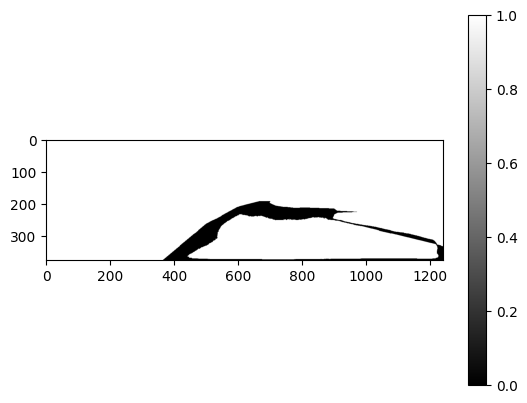

-------------------attack strength r = 1-------------------
(pixel_acc, recall, f1-score, iou) when r = 1: 
(0.9447, 0.7854, 0.839, 0.7227)
show certified pixels in white:


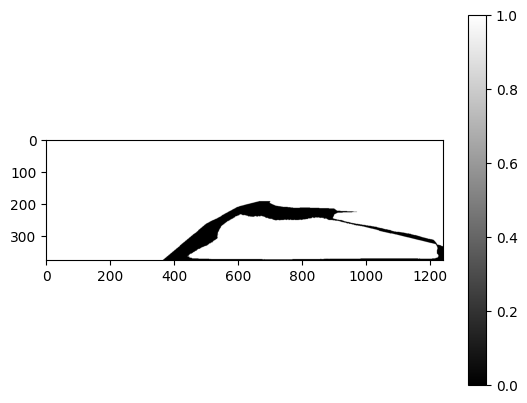

-------------------attack strength r = 2-------------------
(pixel_acc, recall, f1-score, iou) when r = 2: 
(0.9434, 0.7807, 0.8349, 0.7166)
show certified pixels in white:


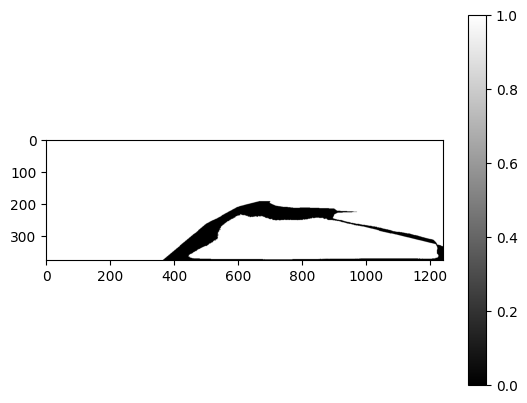

-------------------attack strength r = 3-------------------
(pixel_acc, recall, f1-score, iou) when r = 3: 
(0.9419, 0.7756, 0.8305, 0.7101)
show certified pixels in white:


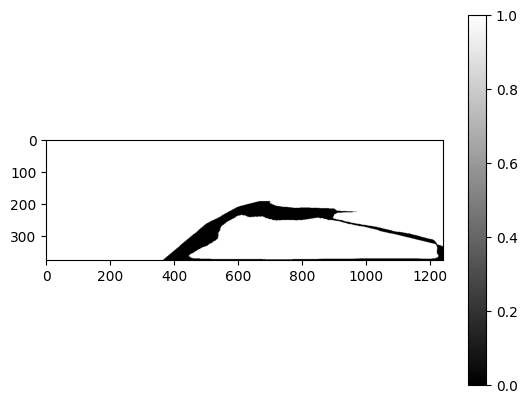

-------------------attack strength r = 4-------------------
(pixel_acc, recall, f1-score, iou) when r = 4: 
(0.9404, 0.7701, 0.8257, 0.7032)
show certified pixels in white:


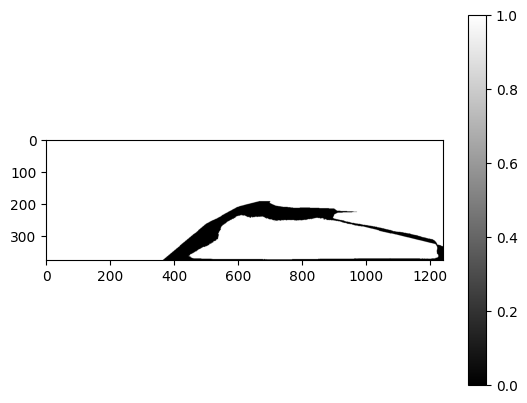

-------------------attack strength r = 5-------------------
(pixel_acc, recall, f1-score, iou) when r = 5: 
(0.9395, 0.7671, 0.8231, 0.6993)
show certified pixels in white:


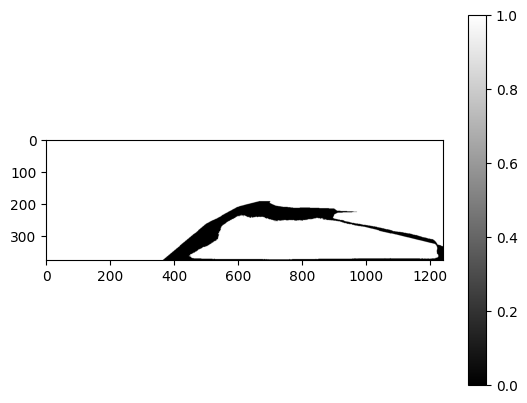

-------------------attack strength r = 6-------------------
(pixel_acc, recall, f1-score, iou) when r = 6: 
(0.9377, 0.7605, 0.8173, 0.6911)
show certified pixels in white:


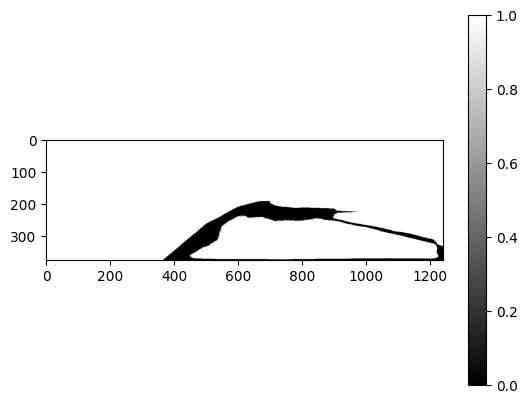

-------------------attack strength r = 7-------------------
(pixel_acc, recall, f1-score, iou) when r = 7: 
(0.9354, 0.7529, 0.8105, 0.6814)
show certified pixels in white:


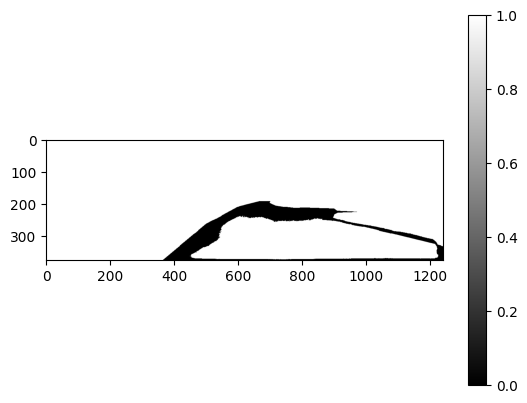

-------------------attack strength r = 8-------------------
(pixel_acc, recall, f1-score, iou) when r = 8: 
(0.9341, 0.7486, 0.8065, 0.6757)
show certified pixels in white:


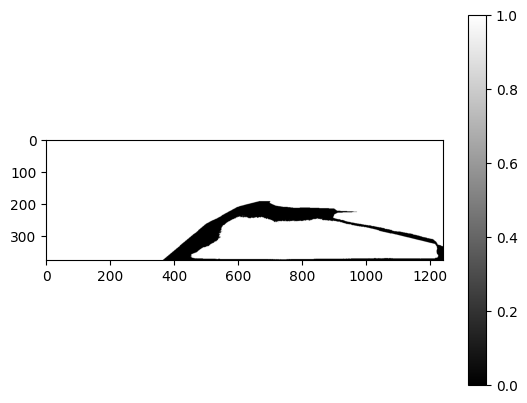

-------------------attack strength r = 9-------------------
(pixel_acc, recall, f1-score, iou) when r = 9: 
(0.9327, 0.7437, 0.8021, 0.6696)
show certified pixels in white:


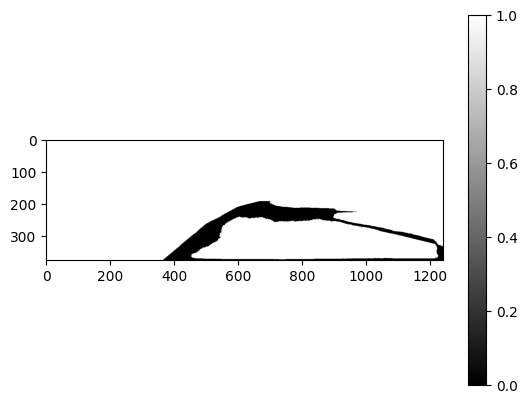

-------------------attack strength r = 10-------------------
(pixel_acc, recall, f1-score, iou) when r = 10: 
(0.9294, 0.7323, 0.7919, 0.6555)
show certified pixels in white:


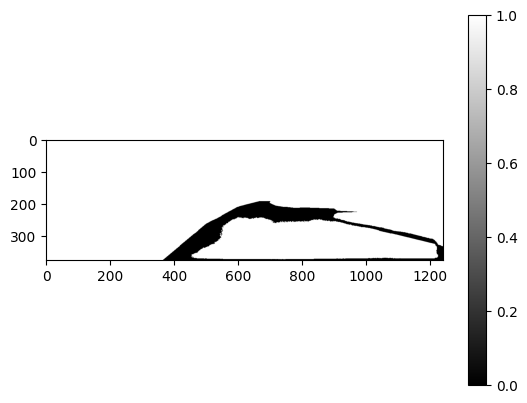

-------------------attack strength r = 11-------------------
(pixel_acc, recall, f1-score, iou) when r = 11: 
(0.9274, 0.7252, 0.7856, 0.6469)
show certified pixels in white:


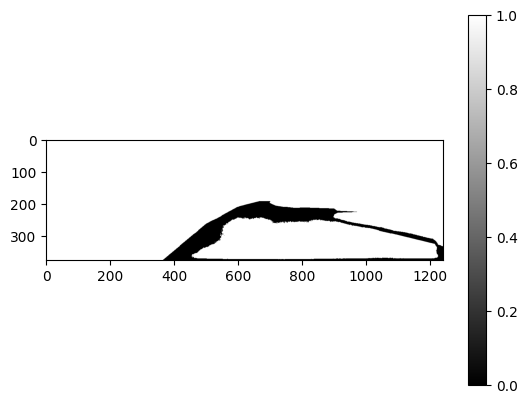

-------------------attack strength r = 12-------------------
(pixel_acc, recall, f1-score, iou) when r = 12: 
(0.925, 0.7169, 0.7781, 0.6368)
show certified pixels in white:


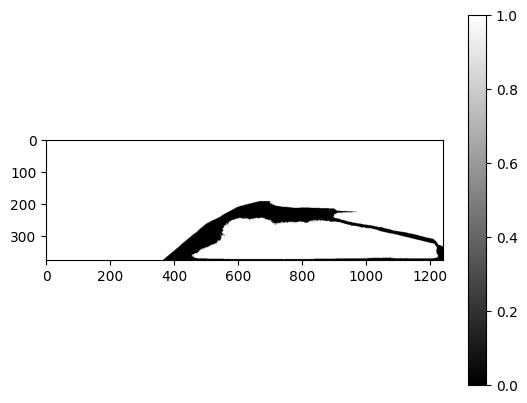

-------------------attack strength r = 13-------------------
(pixel_acc, recall, f1-score, iou) when r = 13: 
(0.9221, 0.7069, 0.769, 0.6246)
show certified pixels in white:


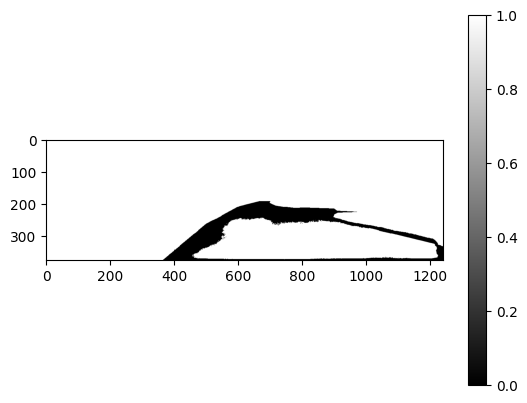

-------------------attack strength r = 14-------------------
(pixel_acc, recall, f1-score, iou) when r = 14: 
(0.9183, 0.6939, 0.757, 0.609)
show certified pixels in white:


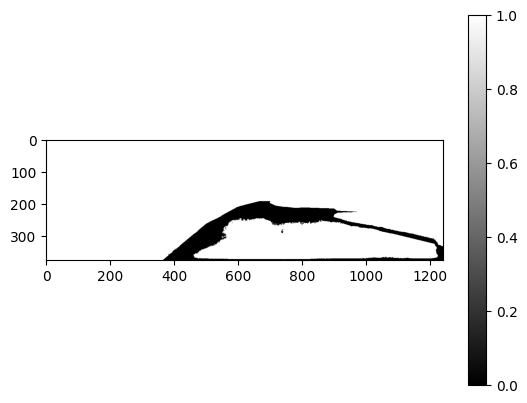

-------------------attack strength r = 15-------------------
(pixel_acc, recall, f1-score, iou) when r = 15: 
(0.9128, 0.6753, 0.7395, 0.5867)
show certified pixels in white:


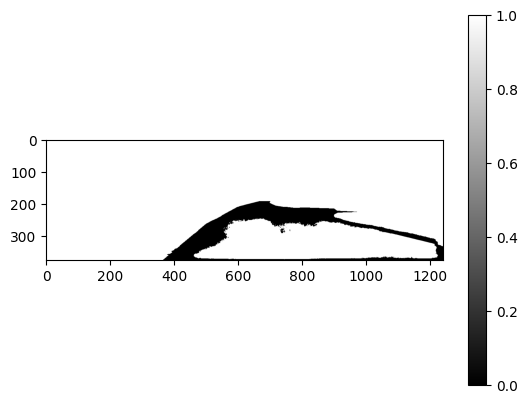

-------------------attack strength r = 16-------------------
(pixel_acc, recall, f1-score, iou) when r = 16: 
(0.9128, 0.6753, 0.7395, 0.5867)
show certified pixels in white:


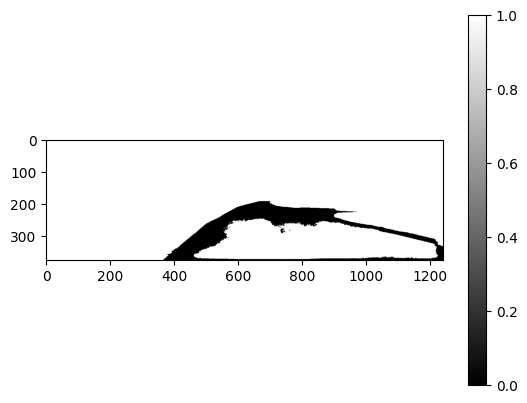

-------------------attack strength r = 17-------------------
(pixel_acc, recall, f1-score, iou) when r = 17: 
(0.1172, 0.0624, 0.0253, 0.0128)
show certified pixels in white:


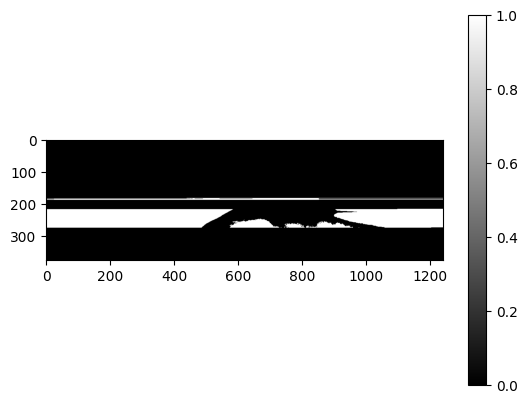

-------------------attack strength r = 18-------------------
(pixel_acc, recall, f1-score, iou) when r = 18: 
(0.0, 0.0, 0.0, 0.0)
show certified pixels in white:


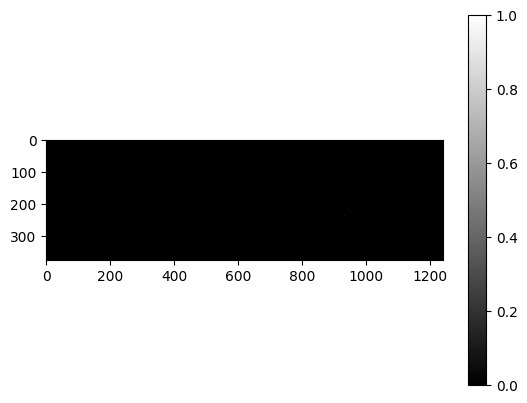

-------------------attack strength r = 19-------------------
(pixel_acc, recall, f1-score, iou) when r = 19: 
(0.0, 0.0, 0.0, 0.0)
show certified pixels in white:


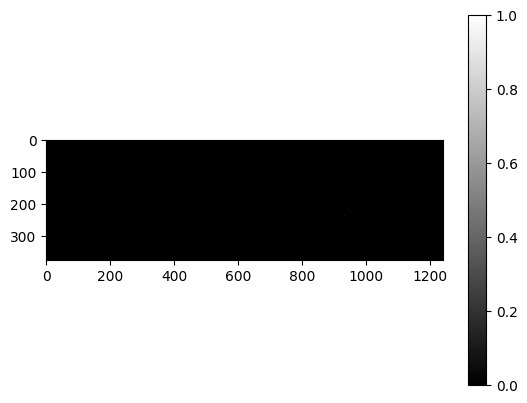

-------------------attack strength r = 20-------------------
(pixel_acc, recall, f1-score, iou) when r = 20: 
(0.0, 0.0, 0.0, 0.0)
show certified pixels in white:


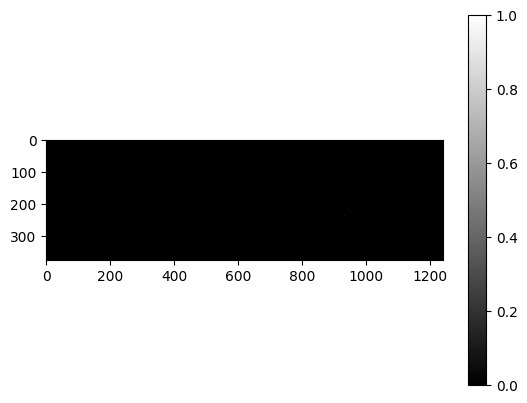

-------------------attack strength r = 21-------------------
(pixel_acc, recall, f1-score, iou) when r = 21: 
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


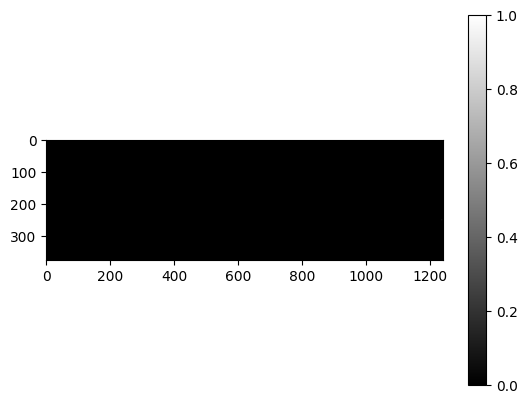

-------------------attack strength r = 22-------------------
(pixel_acc, recall, f1-score, iou) when r = 22: 
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


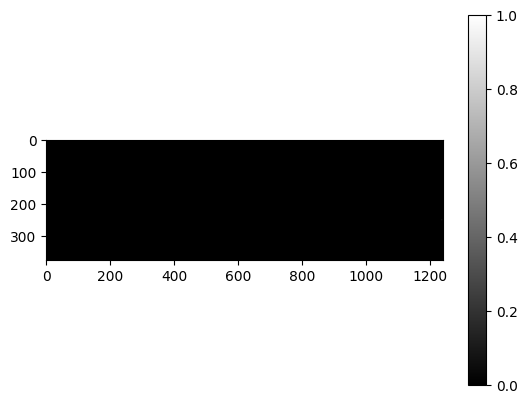

-------------------attack strength r = 23-------------------
(pixel_acc, recall, f1-score, iou) when r = 23: 
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


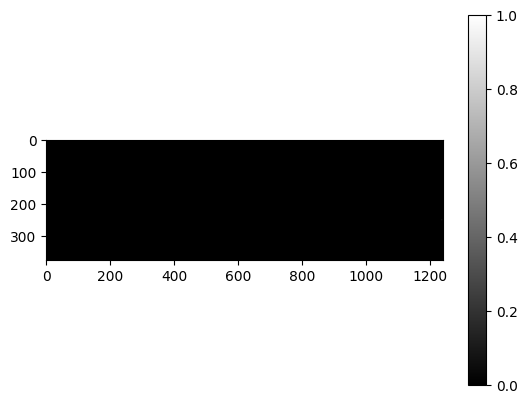

-------------------attack strength r = 24-------------------
(pixel_acc, recall, f1-score, iou) when r = 24: 
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


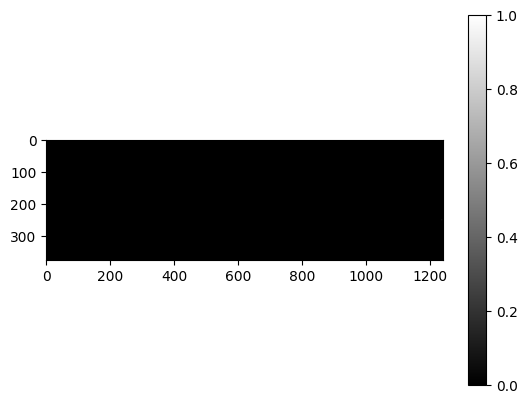

In [10]:
print("========MMCert=========")
n1 = args.n1
n2 = args.n2
k1 = int(n1*args.ablation_ratio_test1)
k2 = int(n2*args.ablation_ratio_test2)

all_outputs = torch.load(os.path.join("output","MMCert"+"_ablation-ratio-test1="+str(args.ablation_ratio_test1)+"_ablation-ratio-test2="+str(args.ablation_ratio_test2)+"_all_outputs.pth"))

all_pred =all_outputs["all_pred"]
all_gt = all_outputs["all_gt"]

all_pred = torch.transpose(all_pred, 0, 1)
all_gt = all_gt[0]

all_count = torch.sum(all_pred, dim=1)
all_predictions = (all_count > args.N/2).int()

alpha_list = get_alpha_list(args,n1,n2,k1,k2, certification_method="MMCert")
certified_metrics_mmcert = []
for r in range(args.r_range): #r is the smaller value between r1 and r2. It represents the attack strength.
    print(f"-------------------attack strength r = {r}-------------------")
    all_alpha = get_all_alpha(all_count, all_gt, alpha_list,r)
    certified_pixels = get_certified_pixels_holm(all_alpha)

    certified_metrics_mmcert.append(calculate_certified_metrics(all_gt, certified_pixels))
    print(f"(pixel_acc, recall, f1-score, iou) when r = {r}: ")
    print(calculate_certified_metrics(all_gt, certified_pixels))
    print("show certified pixels in white:")
    plot_tensor_image(certified_pixels,2)

Visualize certified pixels under different attack strengths for Randomized Ablation

========randomized_ablation=========
torch.Size([58, 100, 375, 1242])


/tmp/ipykernel_3606859/1551038393.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
/tmp/ipykernel_3606859/1551038393.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_count = torch.tensor(all_count)


---------------attack strength r = 0----------------


/tmp/ipykernel_3606859/1551038393.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
/tmp/ipykernel_3606859/1551038393.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  certified_pixels = torch.tensor(certified_pixels)


(pixel_acc, recall, f1-score, iou) when r = 0:
(0.9151, 0.6294, 0.731, 0.5761)
show certified pixels in white:


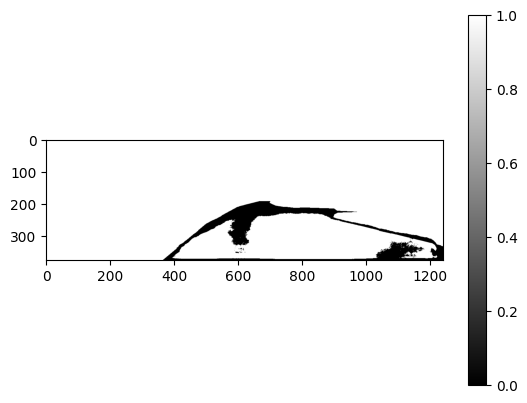

---------------attack strength r = 1----------------
(pixel_acc, recall, f1-score, iou) when r = 1:
(0.9109, 0.6115, 0.7156, 0.5571)
show certified pixels in white:


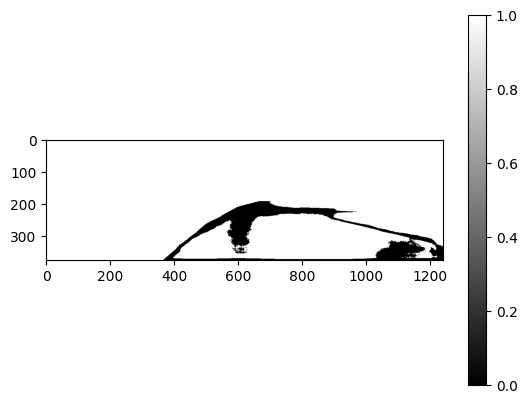

---------------attack strength r = 2----------------
(pixel_acc, recall, f1-score, iou) when r = 2:
(0.9078, 0.5981, 0.704, 0.5432)
show certified pixels in white:


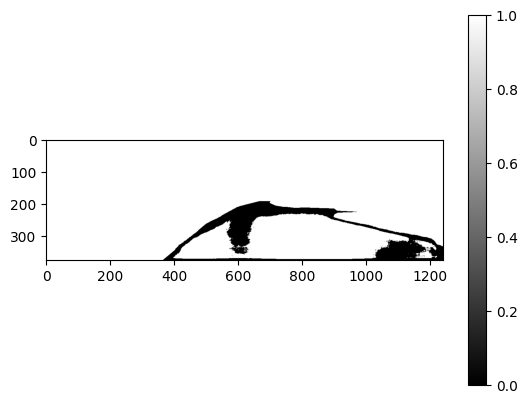

---------------attack strength r = 3----------------
(pixel_acc, recall, f1-score, iou) when r = 3:
(0.9025, 0.5761, 0.6842, 0.52)
show certified pixels in white:


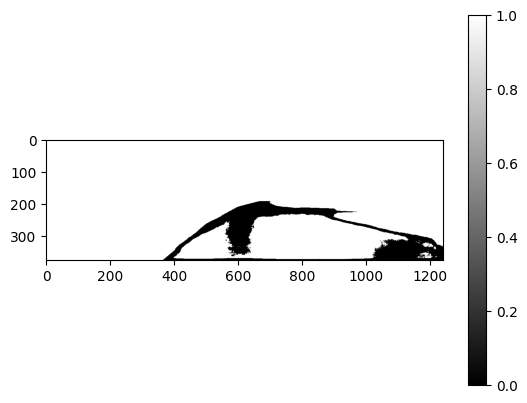

---------------attack strength r = 4----------------
(pixel_acc, recall, f1-score, iou) when r = 4:
(0.8986, 0.56, 0.6694, 0.5031)
show certified pixels in white:


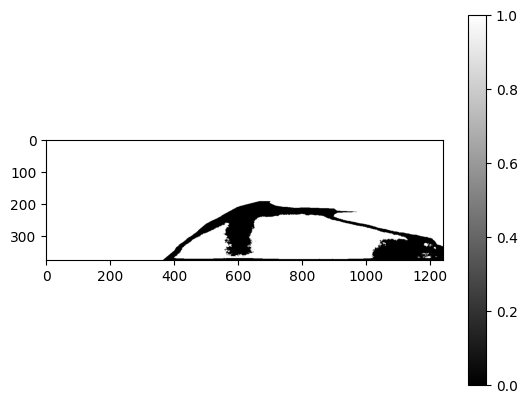

---------------attack strength r = 5----------------
(pixel_acc, recall, f1-score, iou) when r = 5:
(0.8943, 0.542, 0.6528, 0.4845)
show certified pixels in white:


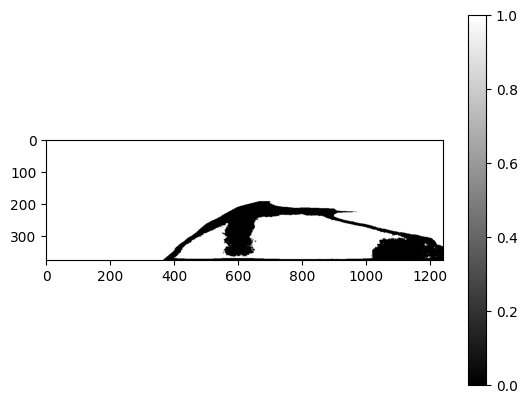

---------------attack strength r = 6----------------
(pixel_acc, recall, f1-score, iou) when r = 6:
(0.8892, 0.5198, 0.6323, 0.4623)
show certified pixels in white:


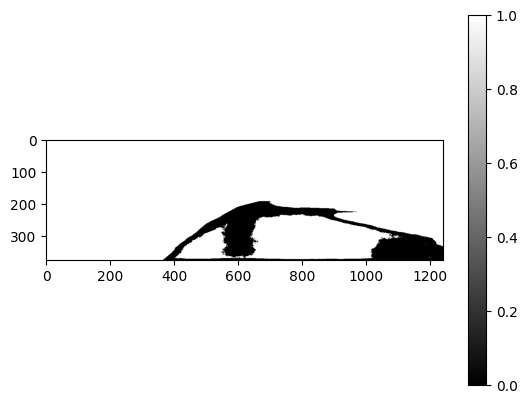

---------------attack strength r = 7----------------
(pixel_acc, recall, f1-score, iou) when r = 7:
(0.8832, 0.4935, 0.6077, 0.4364)
show certified pixels in white:


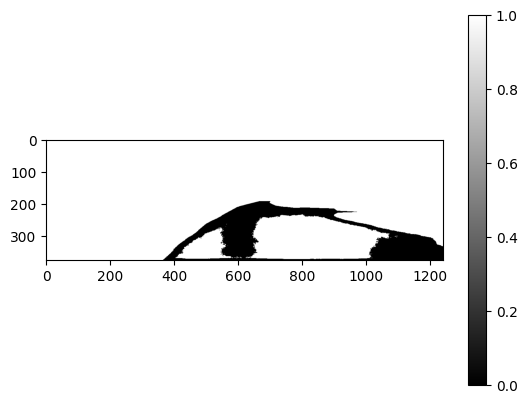

---------------attack strength r = 8----------------
(pixel_acc, recall, f1-score, iou) when r = 8:
(0.8752, 0.458, 0.5737, 0.4023)
show certified pixels in white:


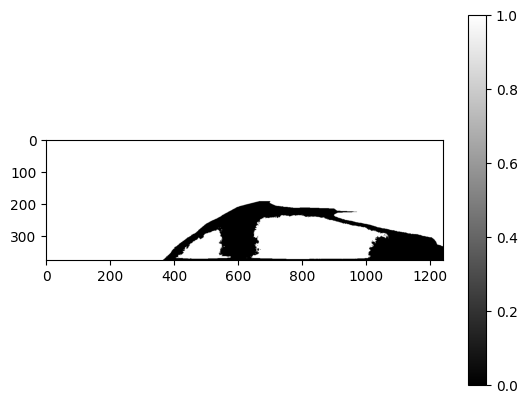

---------------attack strength r = 9----------------
(pixel_acc, recall, f1-score, iou) when r = 9:
(0.8701, 0.4353, 0.5514, 0.3806)
show certified pixels in white:


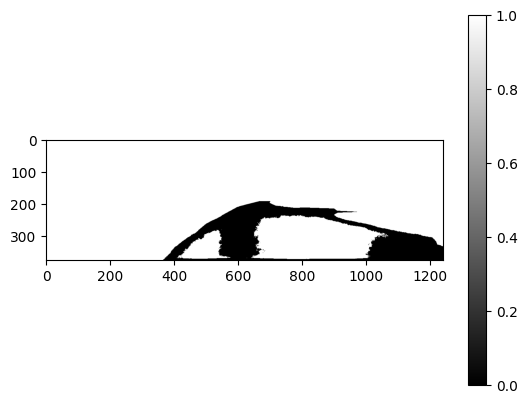

---------------attack strength r = 10----------------
(pixel_acc, recall, f1-score, iou) when r = 10:
(0.8638, 0.4072, 0.5231, 0.3542)
show certified pixels in white:


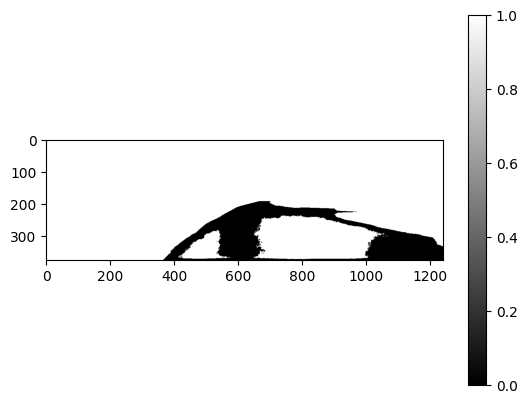

---------------attack strength r = 11----------------
(pixel_acc, recall, f1-score, iou) when r = 11:
(0.8453, 0.3236, 0.4342, 0.2773)
show certified pixels in white:


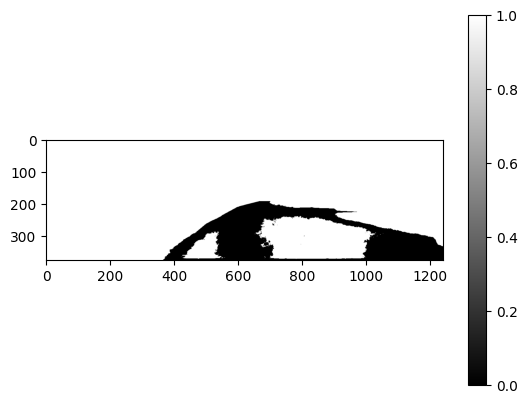

---------------attack strength r = 12----------------
(pixel_acc, recall, f1-score, iou) when r = 12:
(0.8261, 0.2396, 0.3358, 0.2017)
show certified pixels in white:


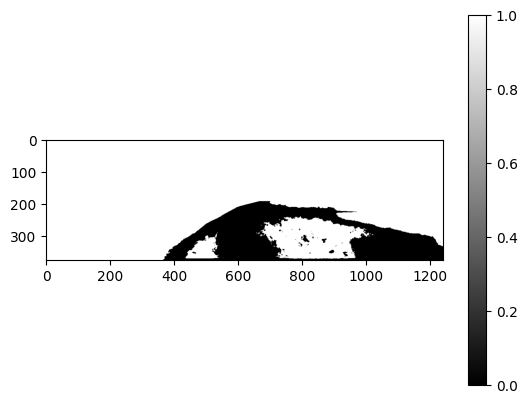

---------------attack strength r = 13----------------
(pixel_acc, recall, f1-score, iou) when r = 13:
(0.0461, 0.0077, 0.0029, 0.0015)
show certified pixels in white:


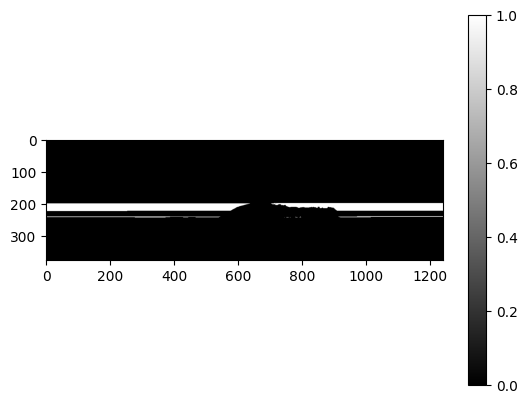

---------------attack strength r = 14----------------
(pixel_acc, recall, f1-score, iou) when r = 14:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


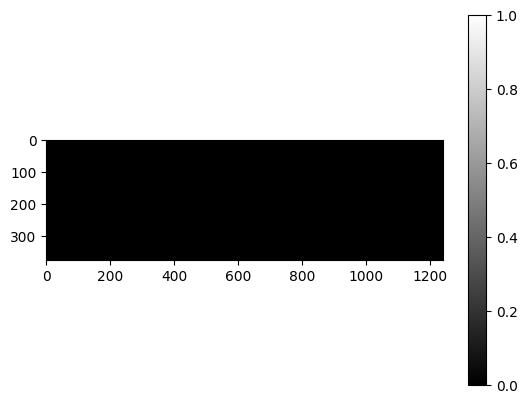

---------------attack strength r = 15----------------
(pixel_acc, recall, f1-score, iou) when r = 15:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


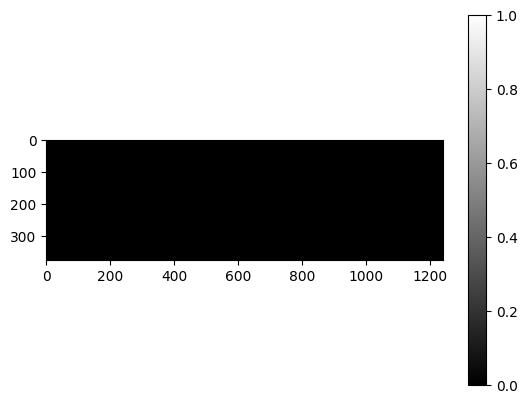

---------------attack strength r = 16----------------
(pixel_acc, recall, f1-score, iou) when r = 16:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


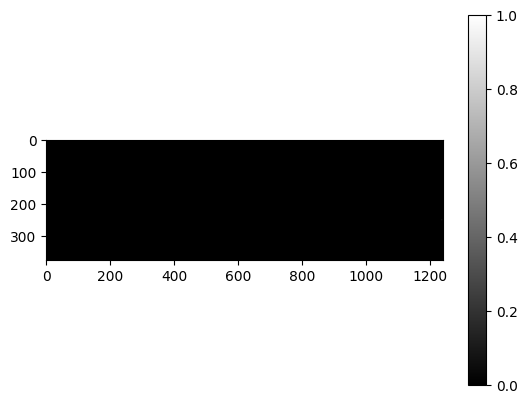

---------------attack strength r = 17----------------
(pixel_acc, recall, f1-score, iou) when r = 17:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


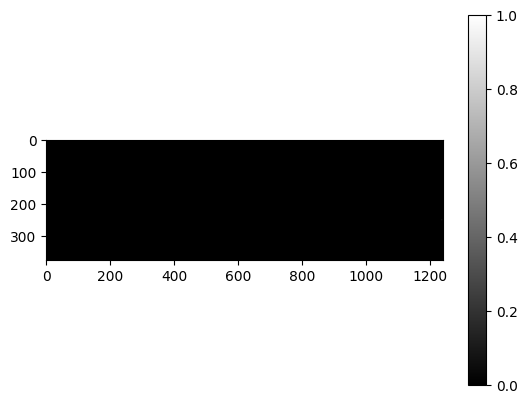

---------------attack strength r = 18----------------
(pixel_acc, recall, f1-score, iou) when r = 18:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


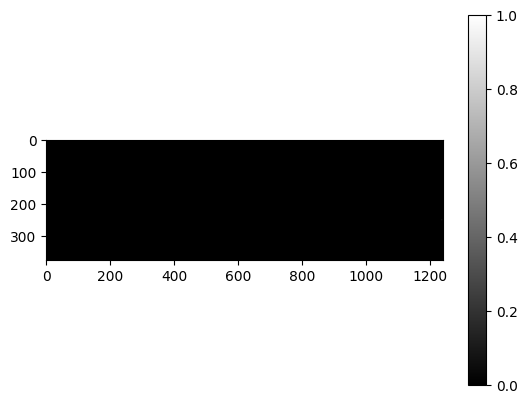

---------------attack strength r = 19----------------
(pixel_acc, recall, f1-score, iou) when r = 19:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


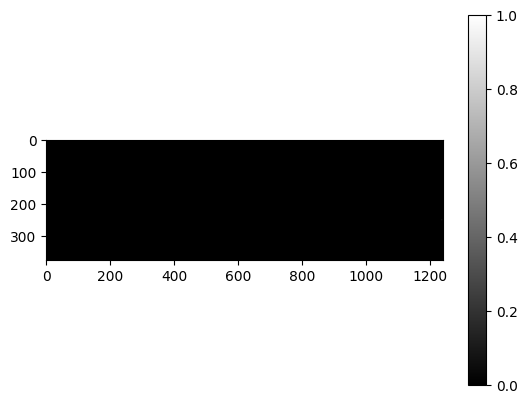

---------------attack strength r = 20----------------
(pixel_acc, recall, f1-score, iou) when r = 20:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


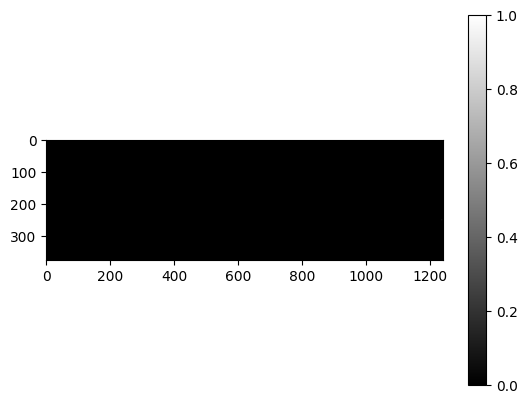

---------------attack strength r = 21----------------
(pixel_acc, recall, f1-score, iou) when r = 21:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


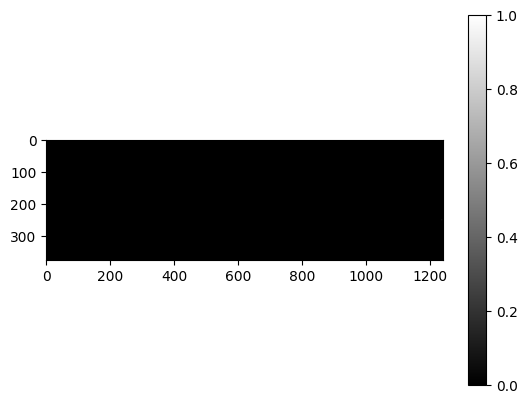

---------------attack strength r = 22----------------
(pixel_acc, recall, f1-score, iou) when r = 22:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


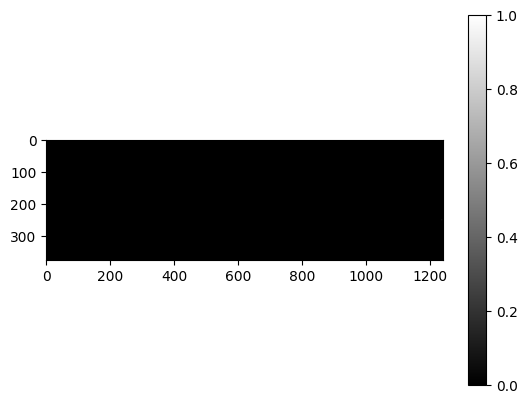

---------------attack strength r = 23----------------
(pixel_acc, recall, f1-score, iou) when r = 23:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


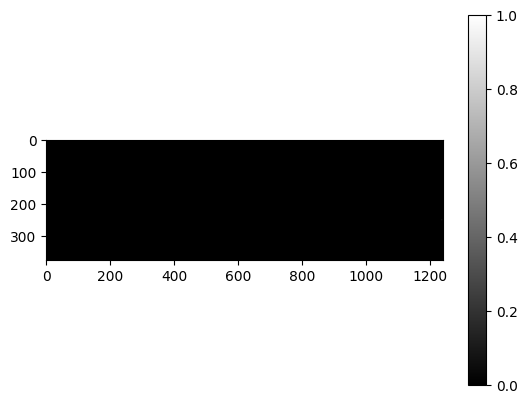

---------------attack strength r = 24----------------
(pixel_acc, recall, f1-score, iou) when r = 24:
(0.0, 0.0, 0, 0.0)
show certified pixels in white:


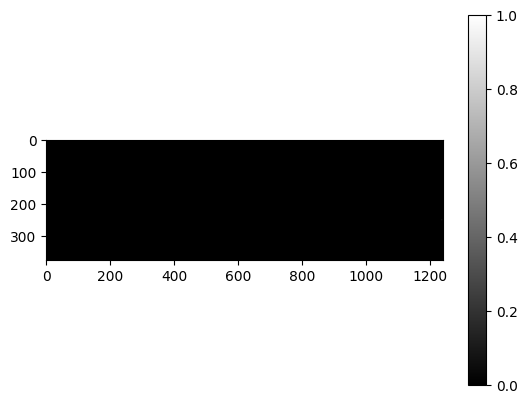

In [8]:
print("========randomized_ablation=========")
n1 = args.n1
n2 = args.n2
k1 = int(n1*args.ablation_ratio_test)
k2 = int(n2*args.ablation_ratio_test)
all_outputs = torch.load(os.path.join("output","randomized_ablation"+"_ablation-ratio-test="+str(args.ablation_ratio_test)+"_all_outputs.pth"))
all_pred =all_outputs["all_pred"]
all_gt = all_outputs["all_gt"]
all_pred = torch.transpose(all_pred, 0, 1)
all_gt = all_gt[0]

all_count = torch.sum(all_pred, dim=1)
all_predictions = (all_count > args.N/2).int()
print(all_pred.shape)

alpha_list = get_alpha_list(args,n1,n2,k1,k2, certification_method="randomized_ablation")
certified_metrics_ra = []
for r in range(args.r_range): #r is the smaller value between r1 and r2. It represents the attack strength.
    all_alpha = get_all_alpha(all_count, all_gt, alpha_list,r)
    print(f"---------------attack strength r = {r}----------------")
    certified_pixels = get_certified_pixels_holm(all_alpha)

    certified_metrics_ra.append(calculate_certified_metrics(all_gt, certified_pixels))
    print(f"(pixel_acc, recall, f1-score, iou) when r = {r}:")
    print(calculate_certified_metrics(all_gt, certified_pixels))
    print("show certified pixels in white:")
    plot_tensor_image(certified_pixels,2)


Visualize the results: plot figures to compare these two methods

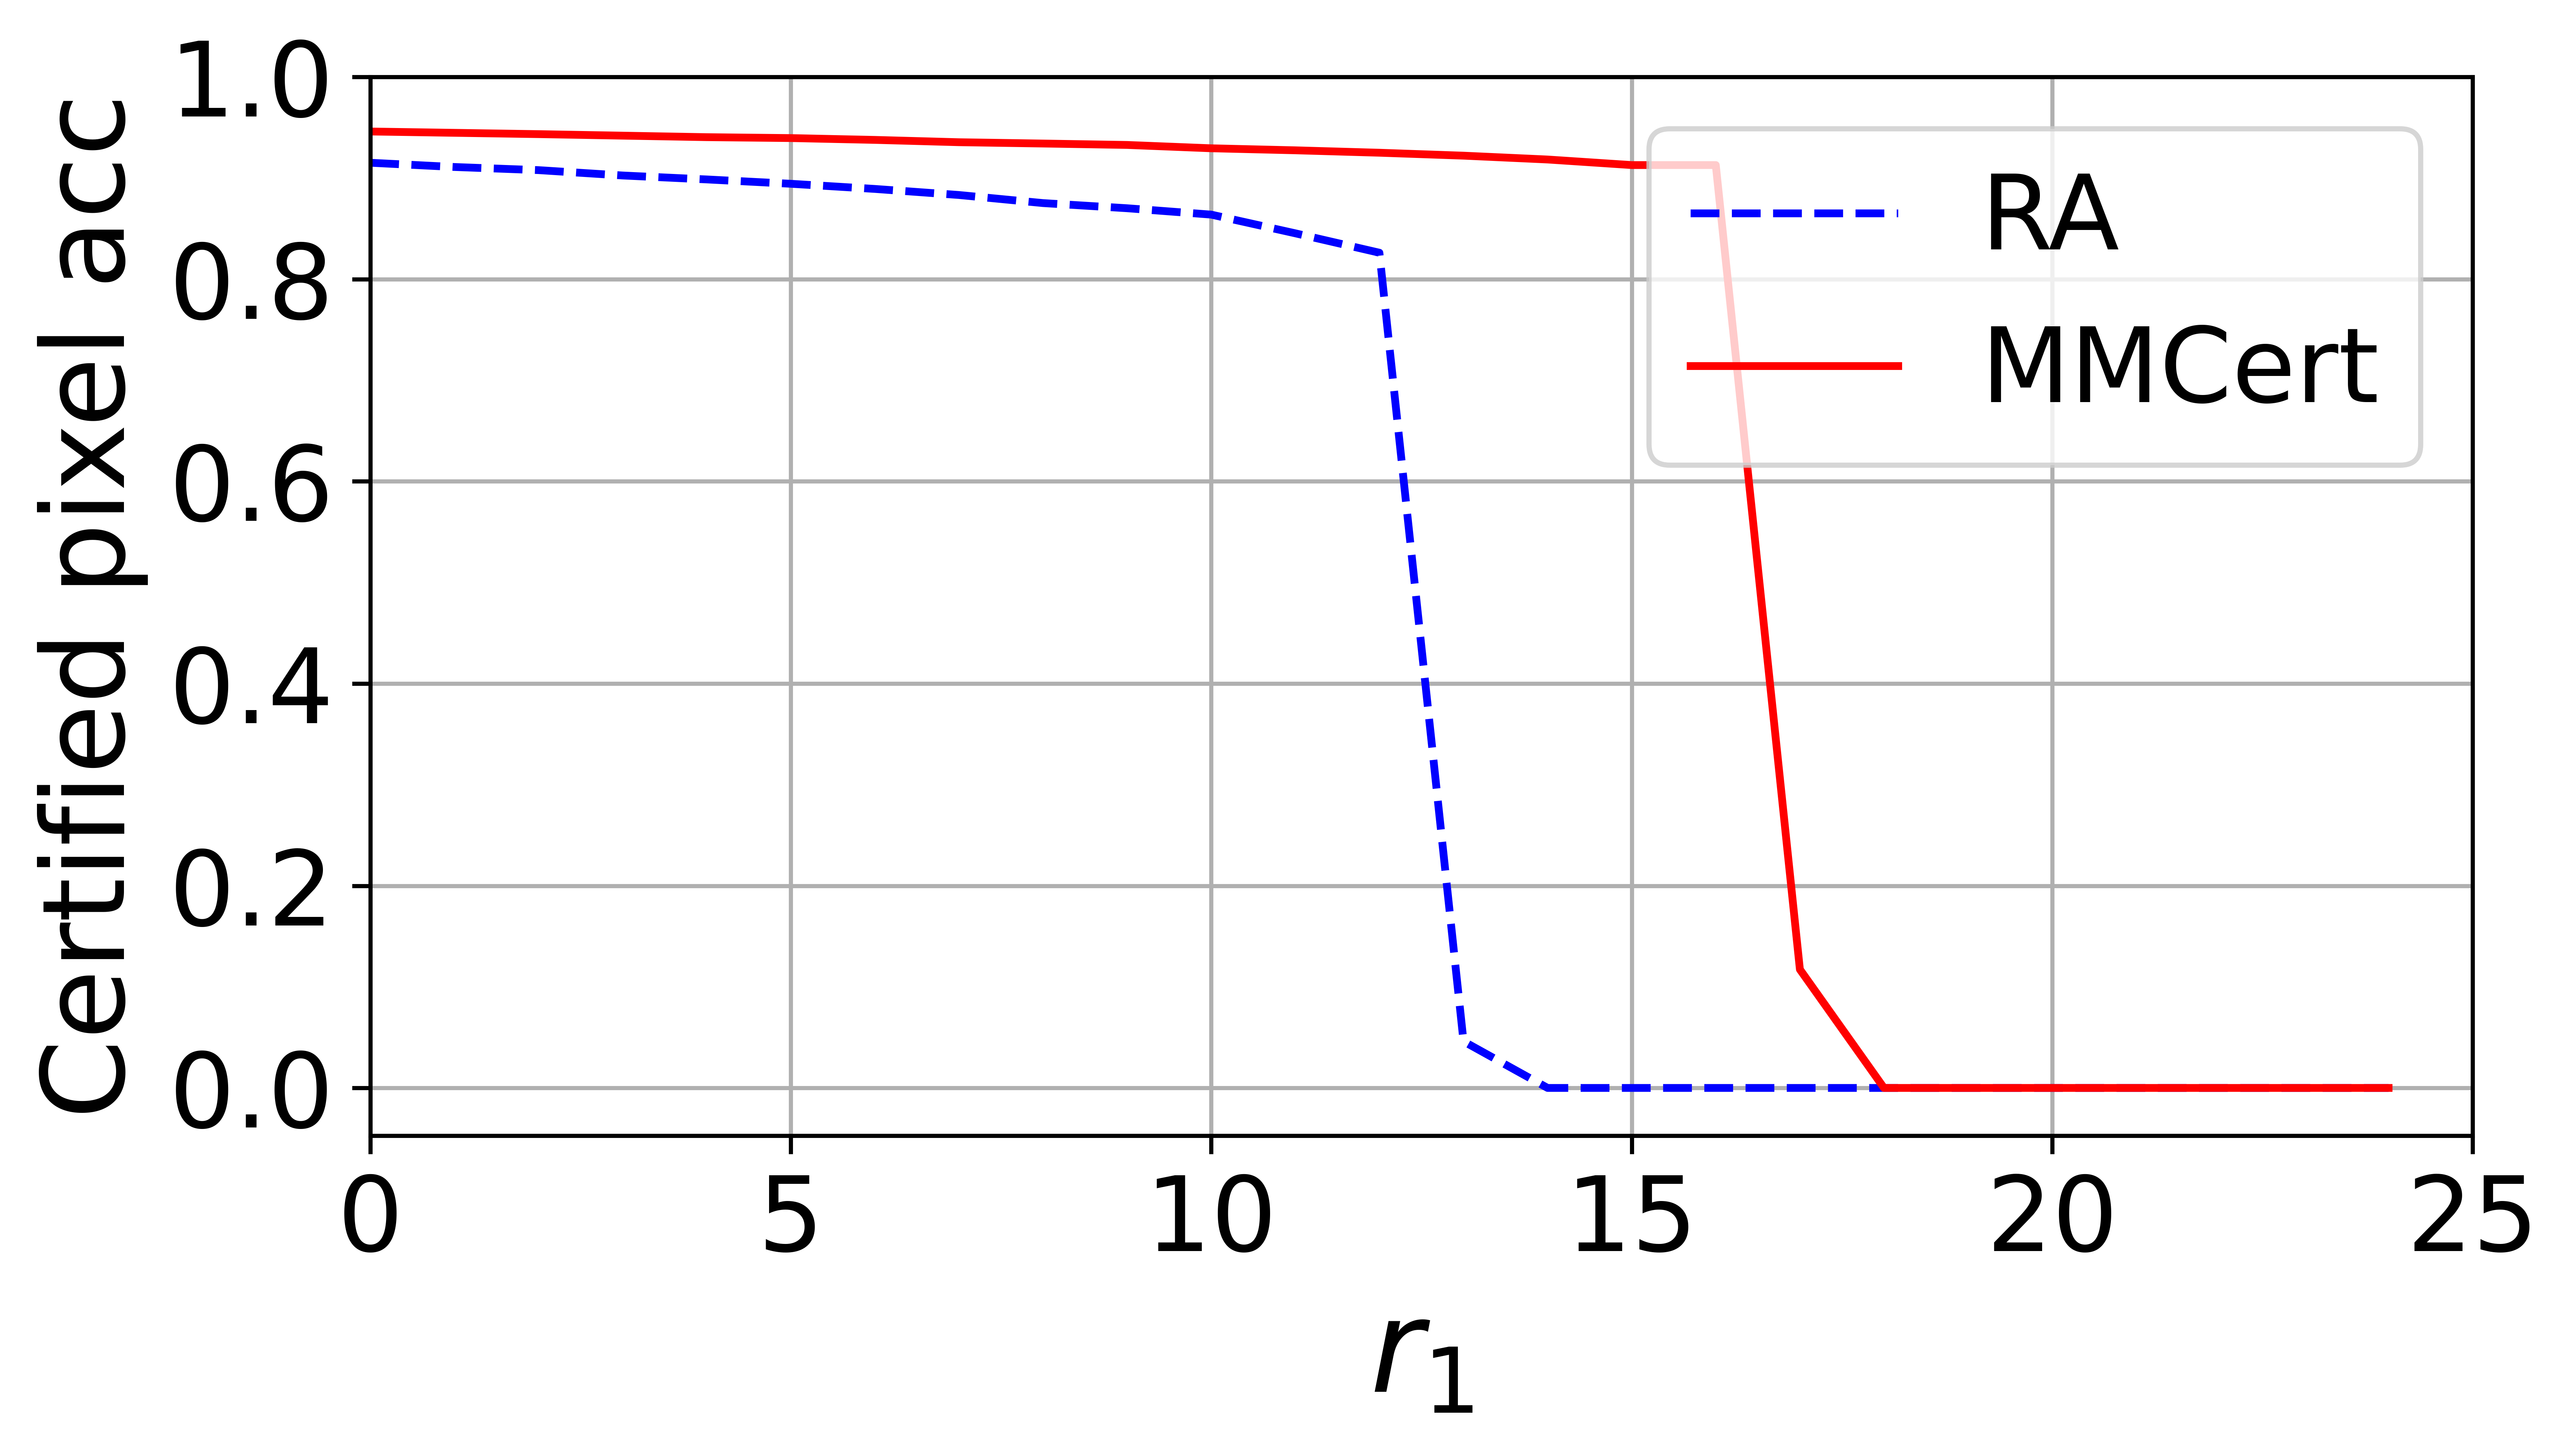

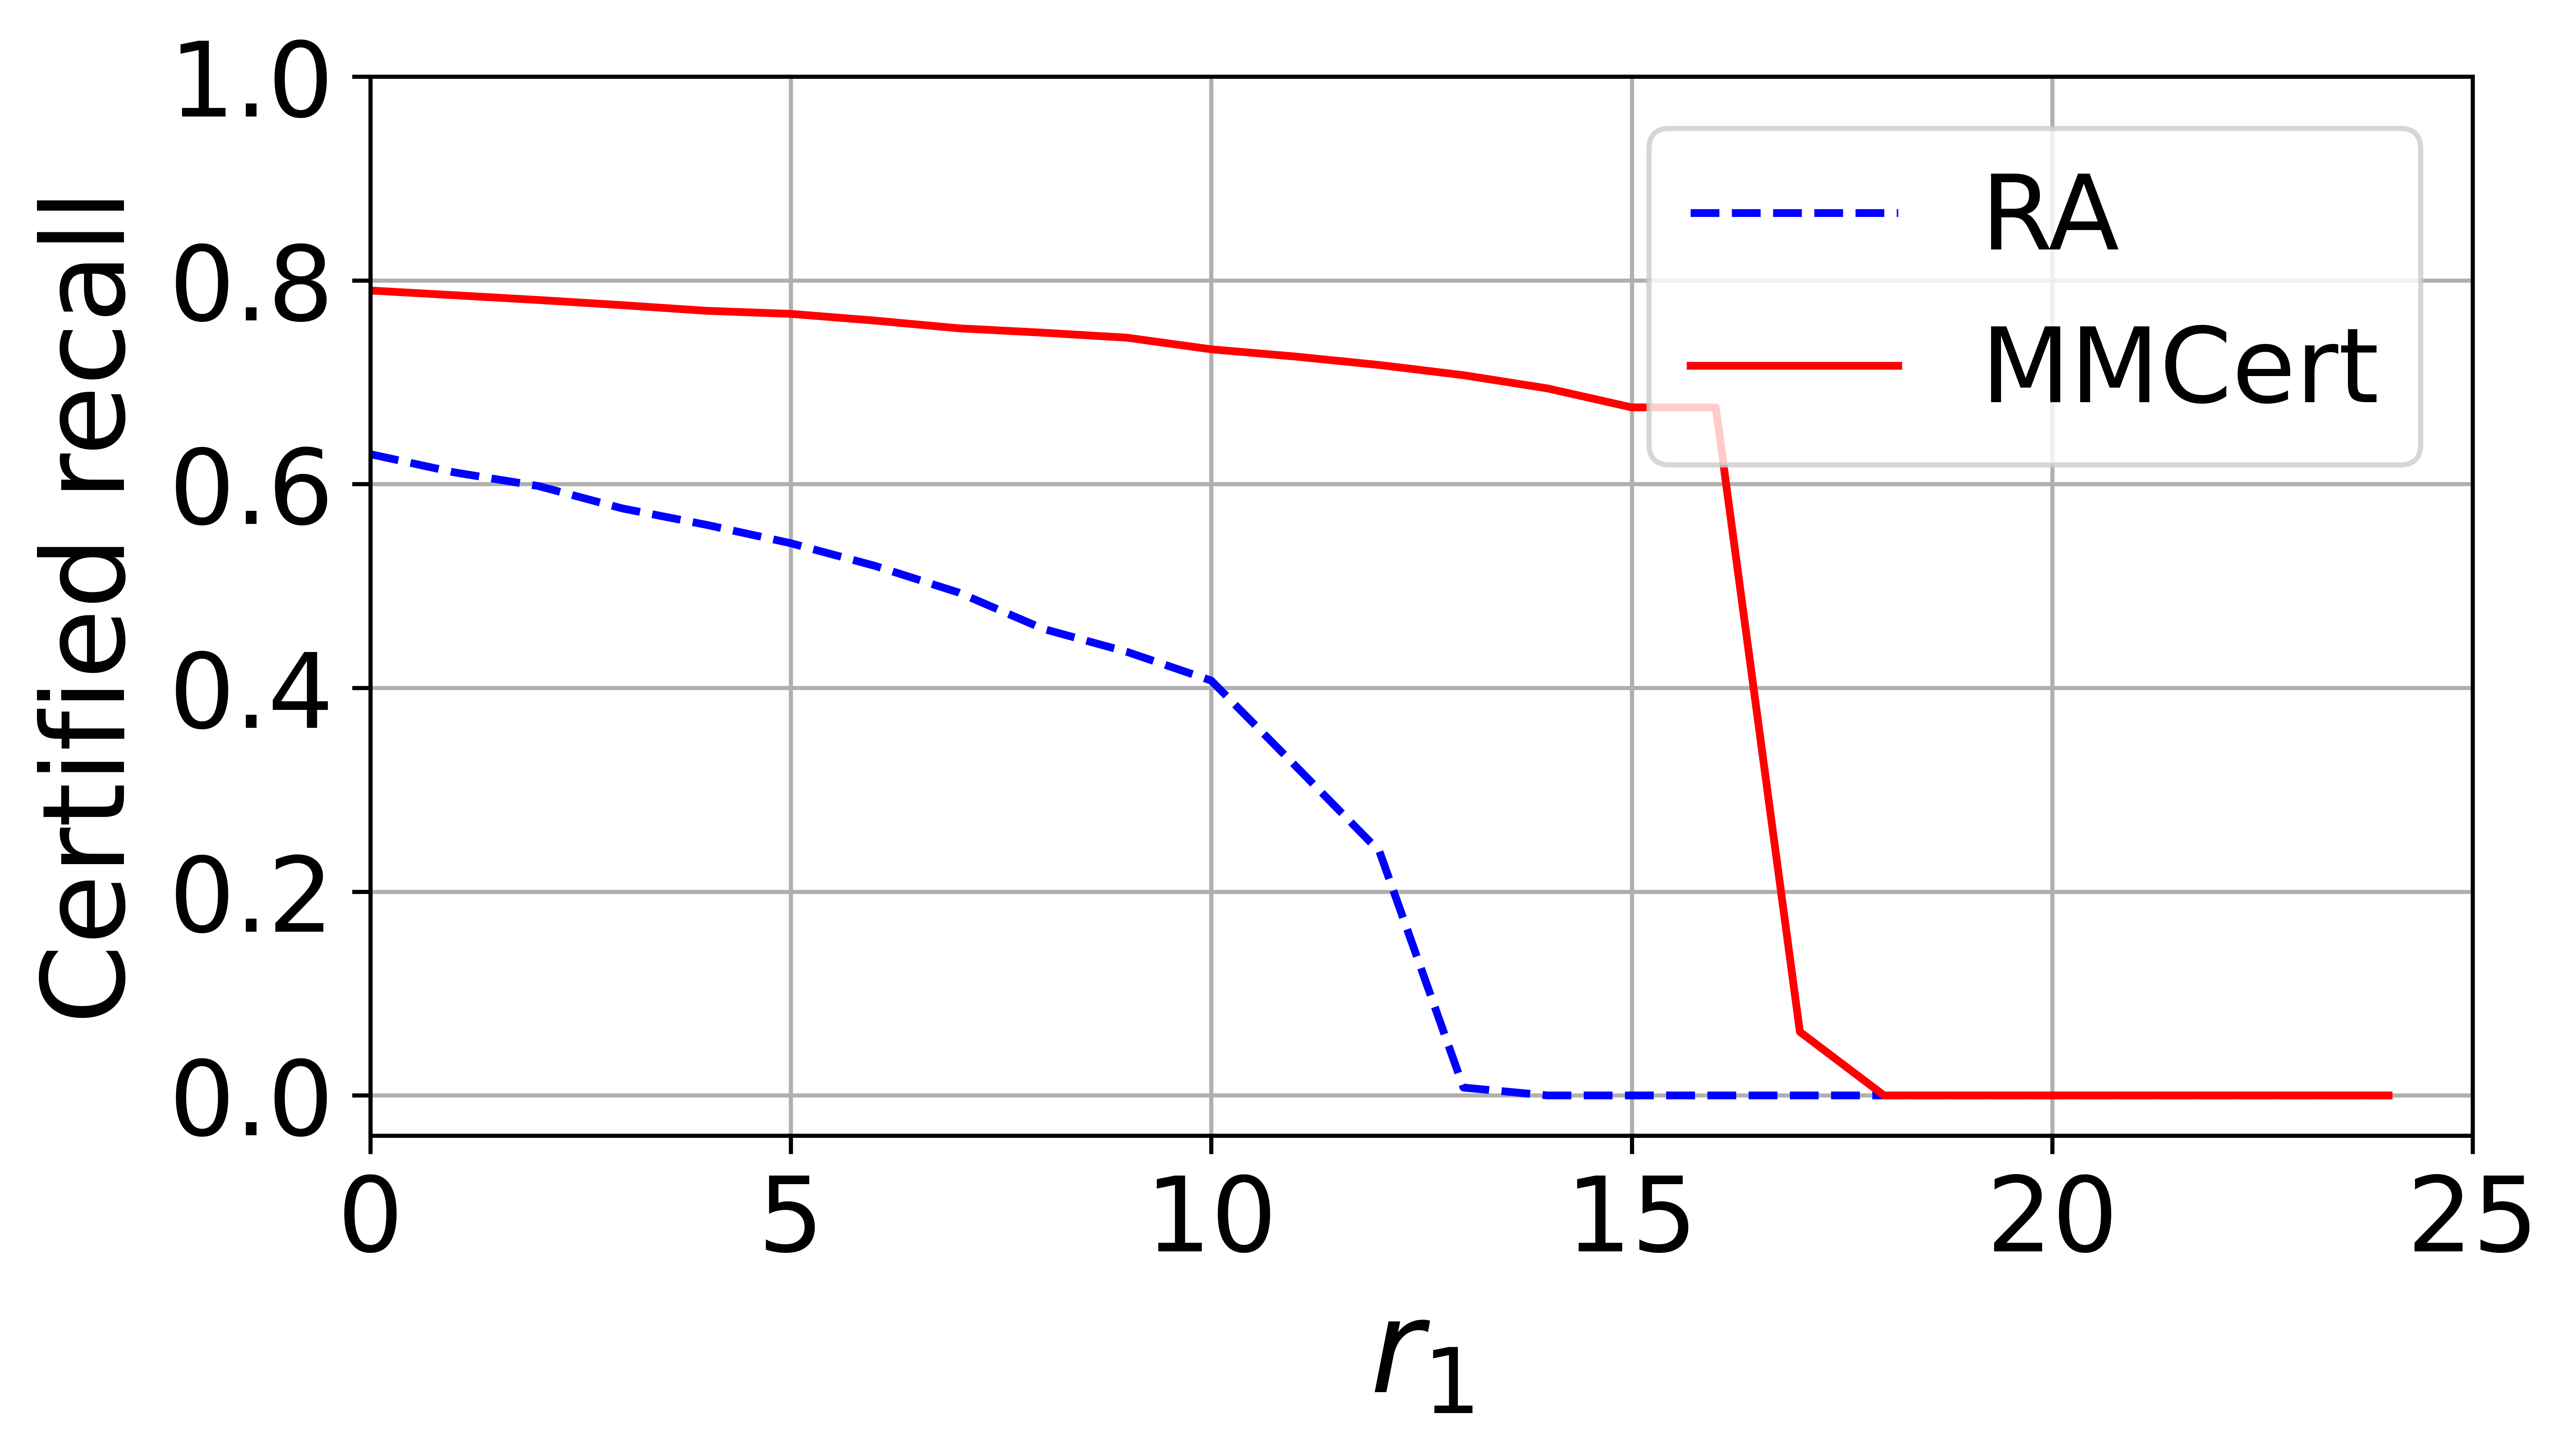

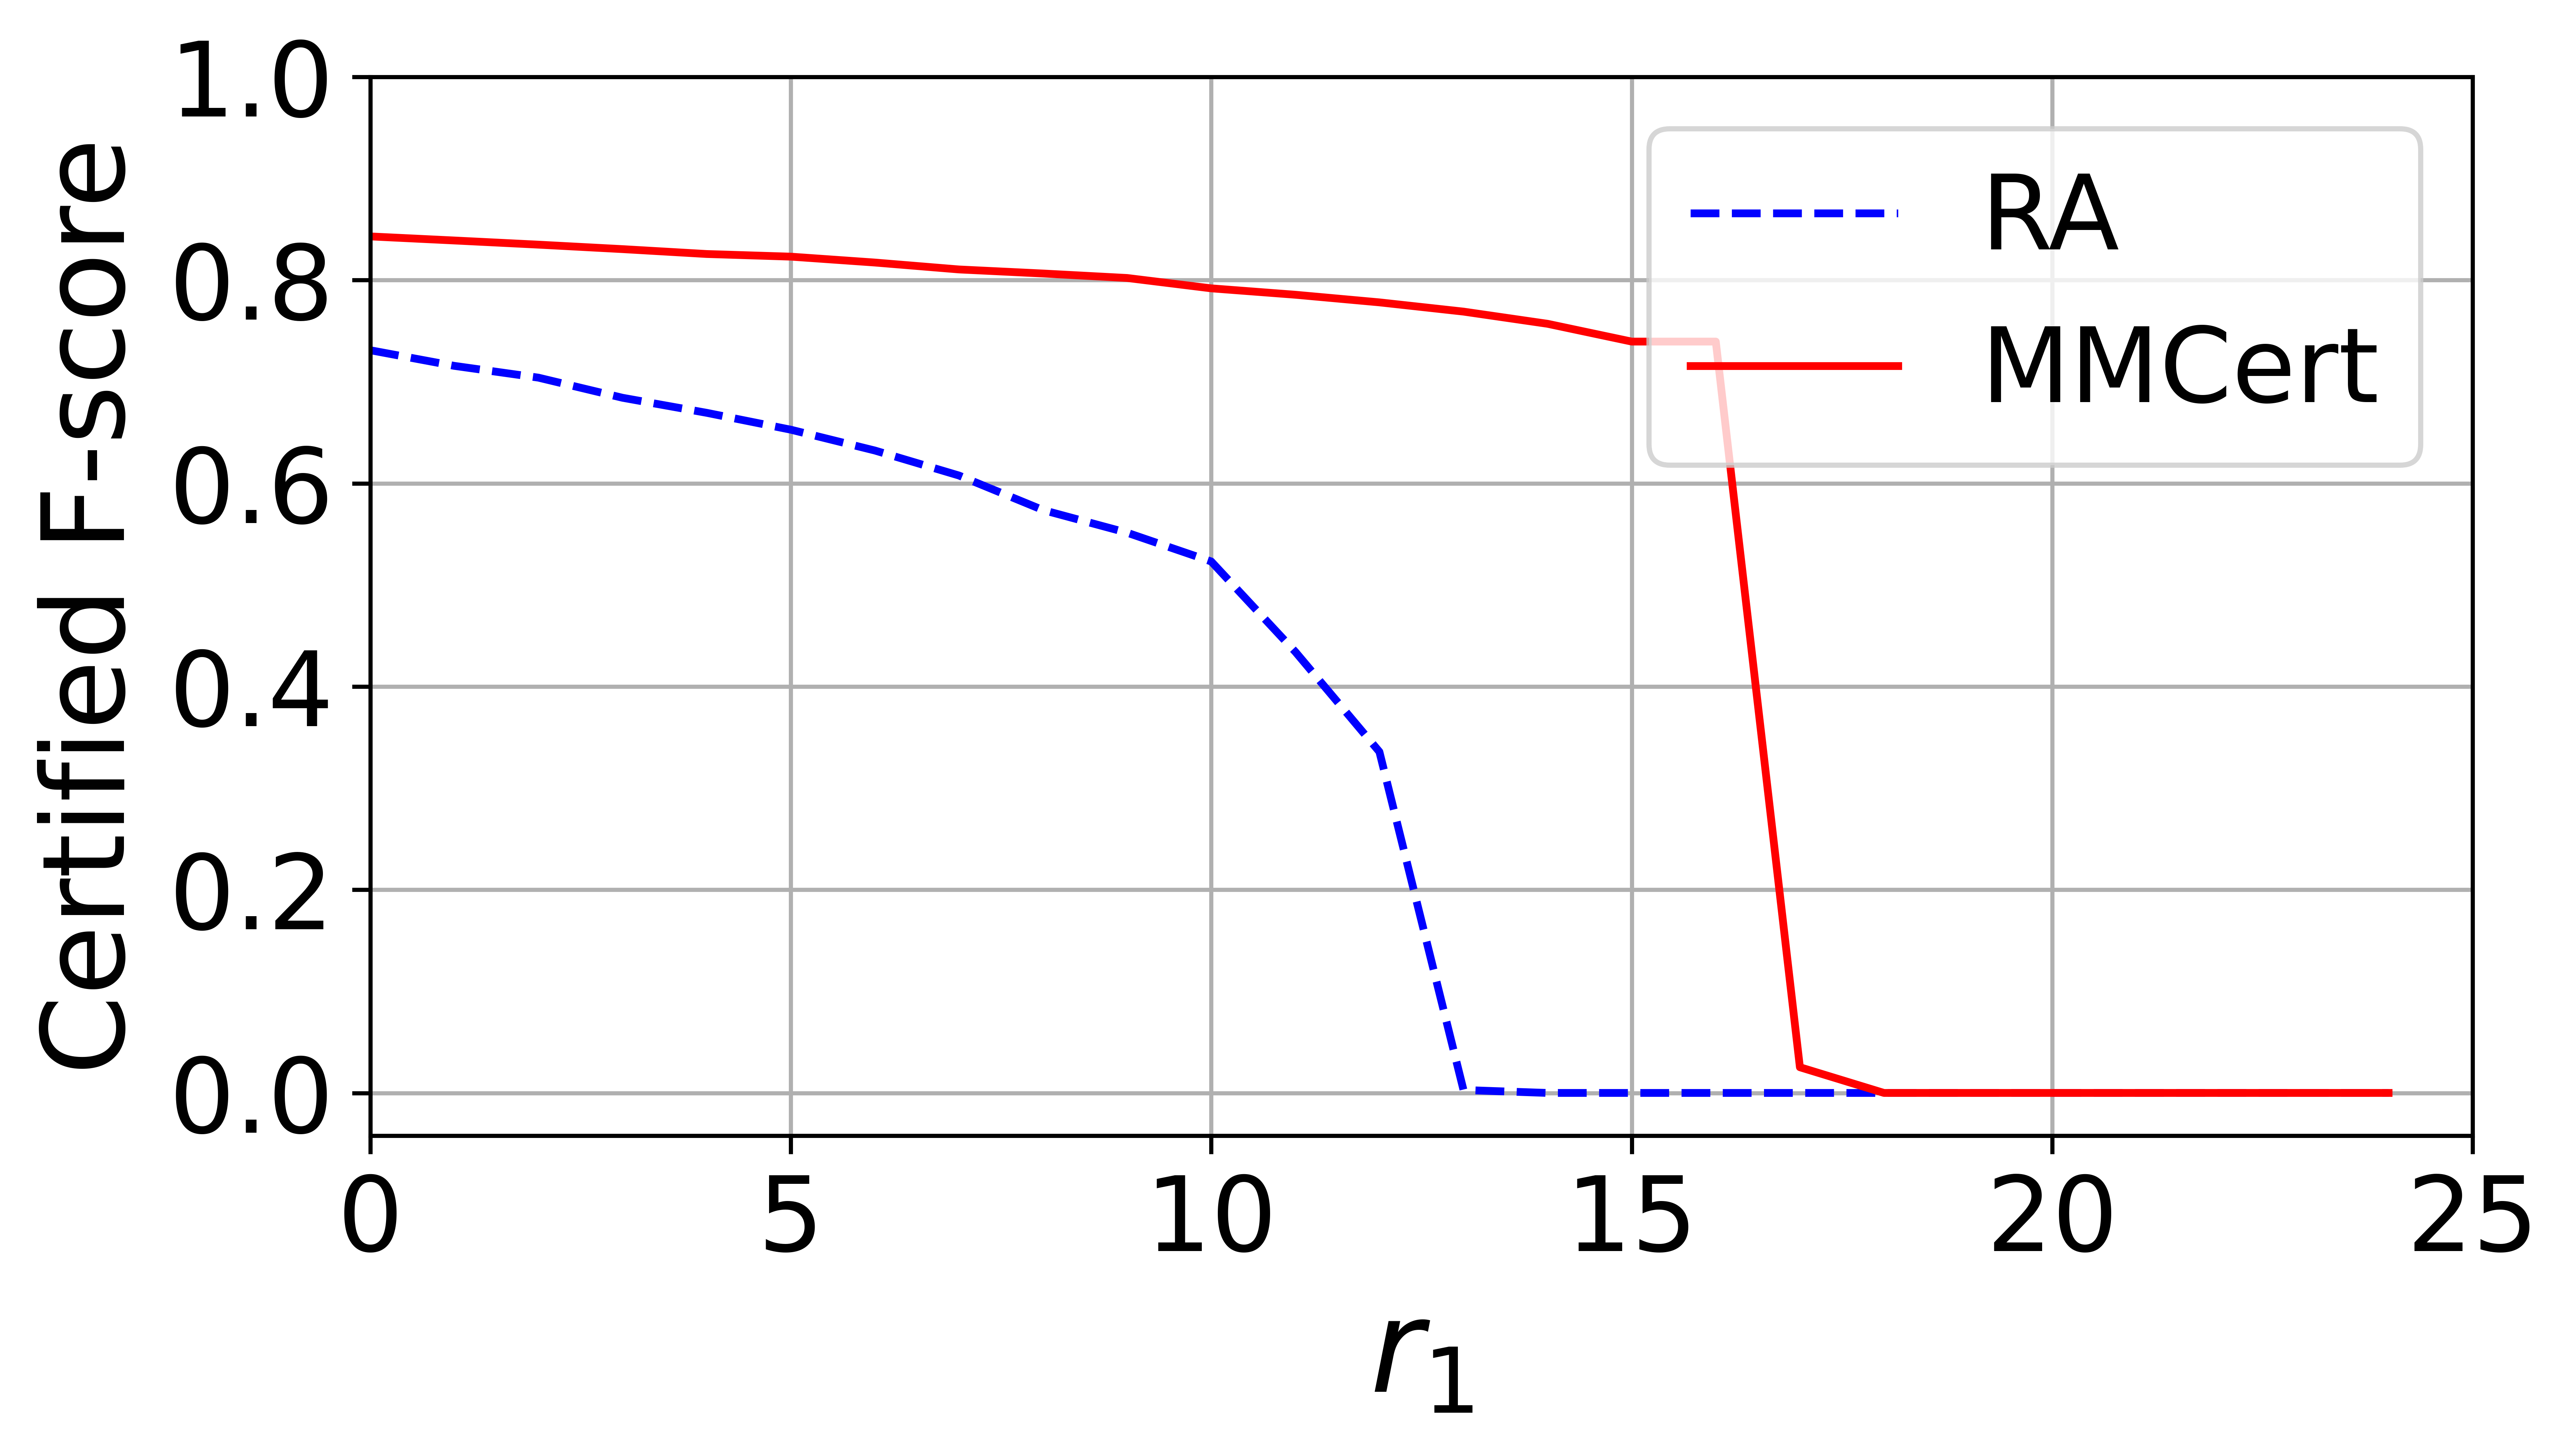

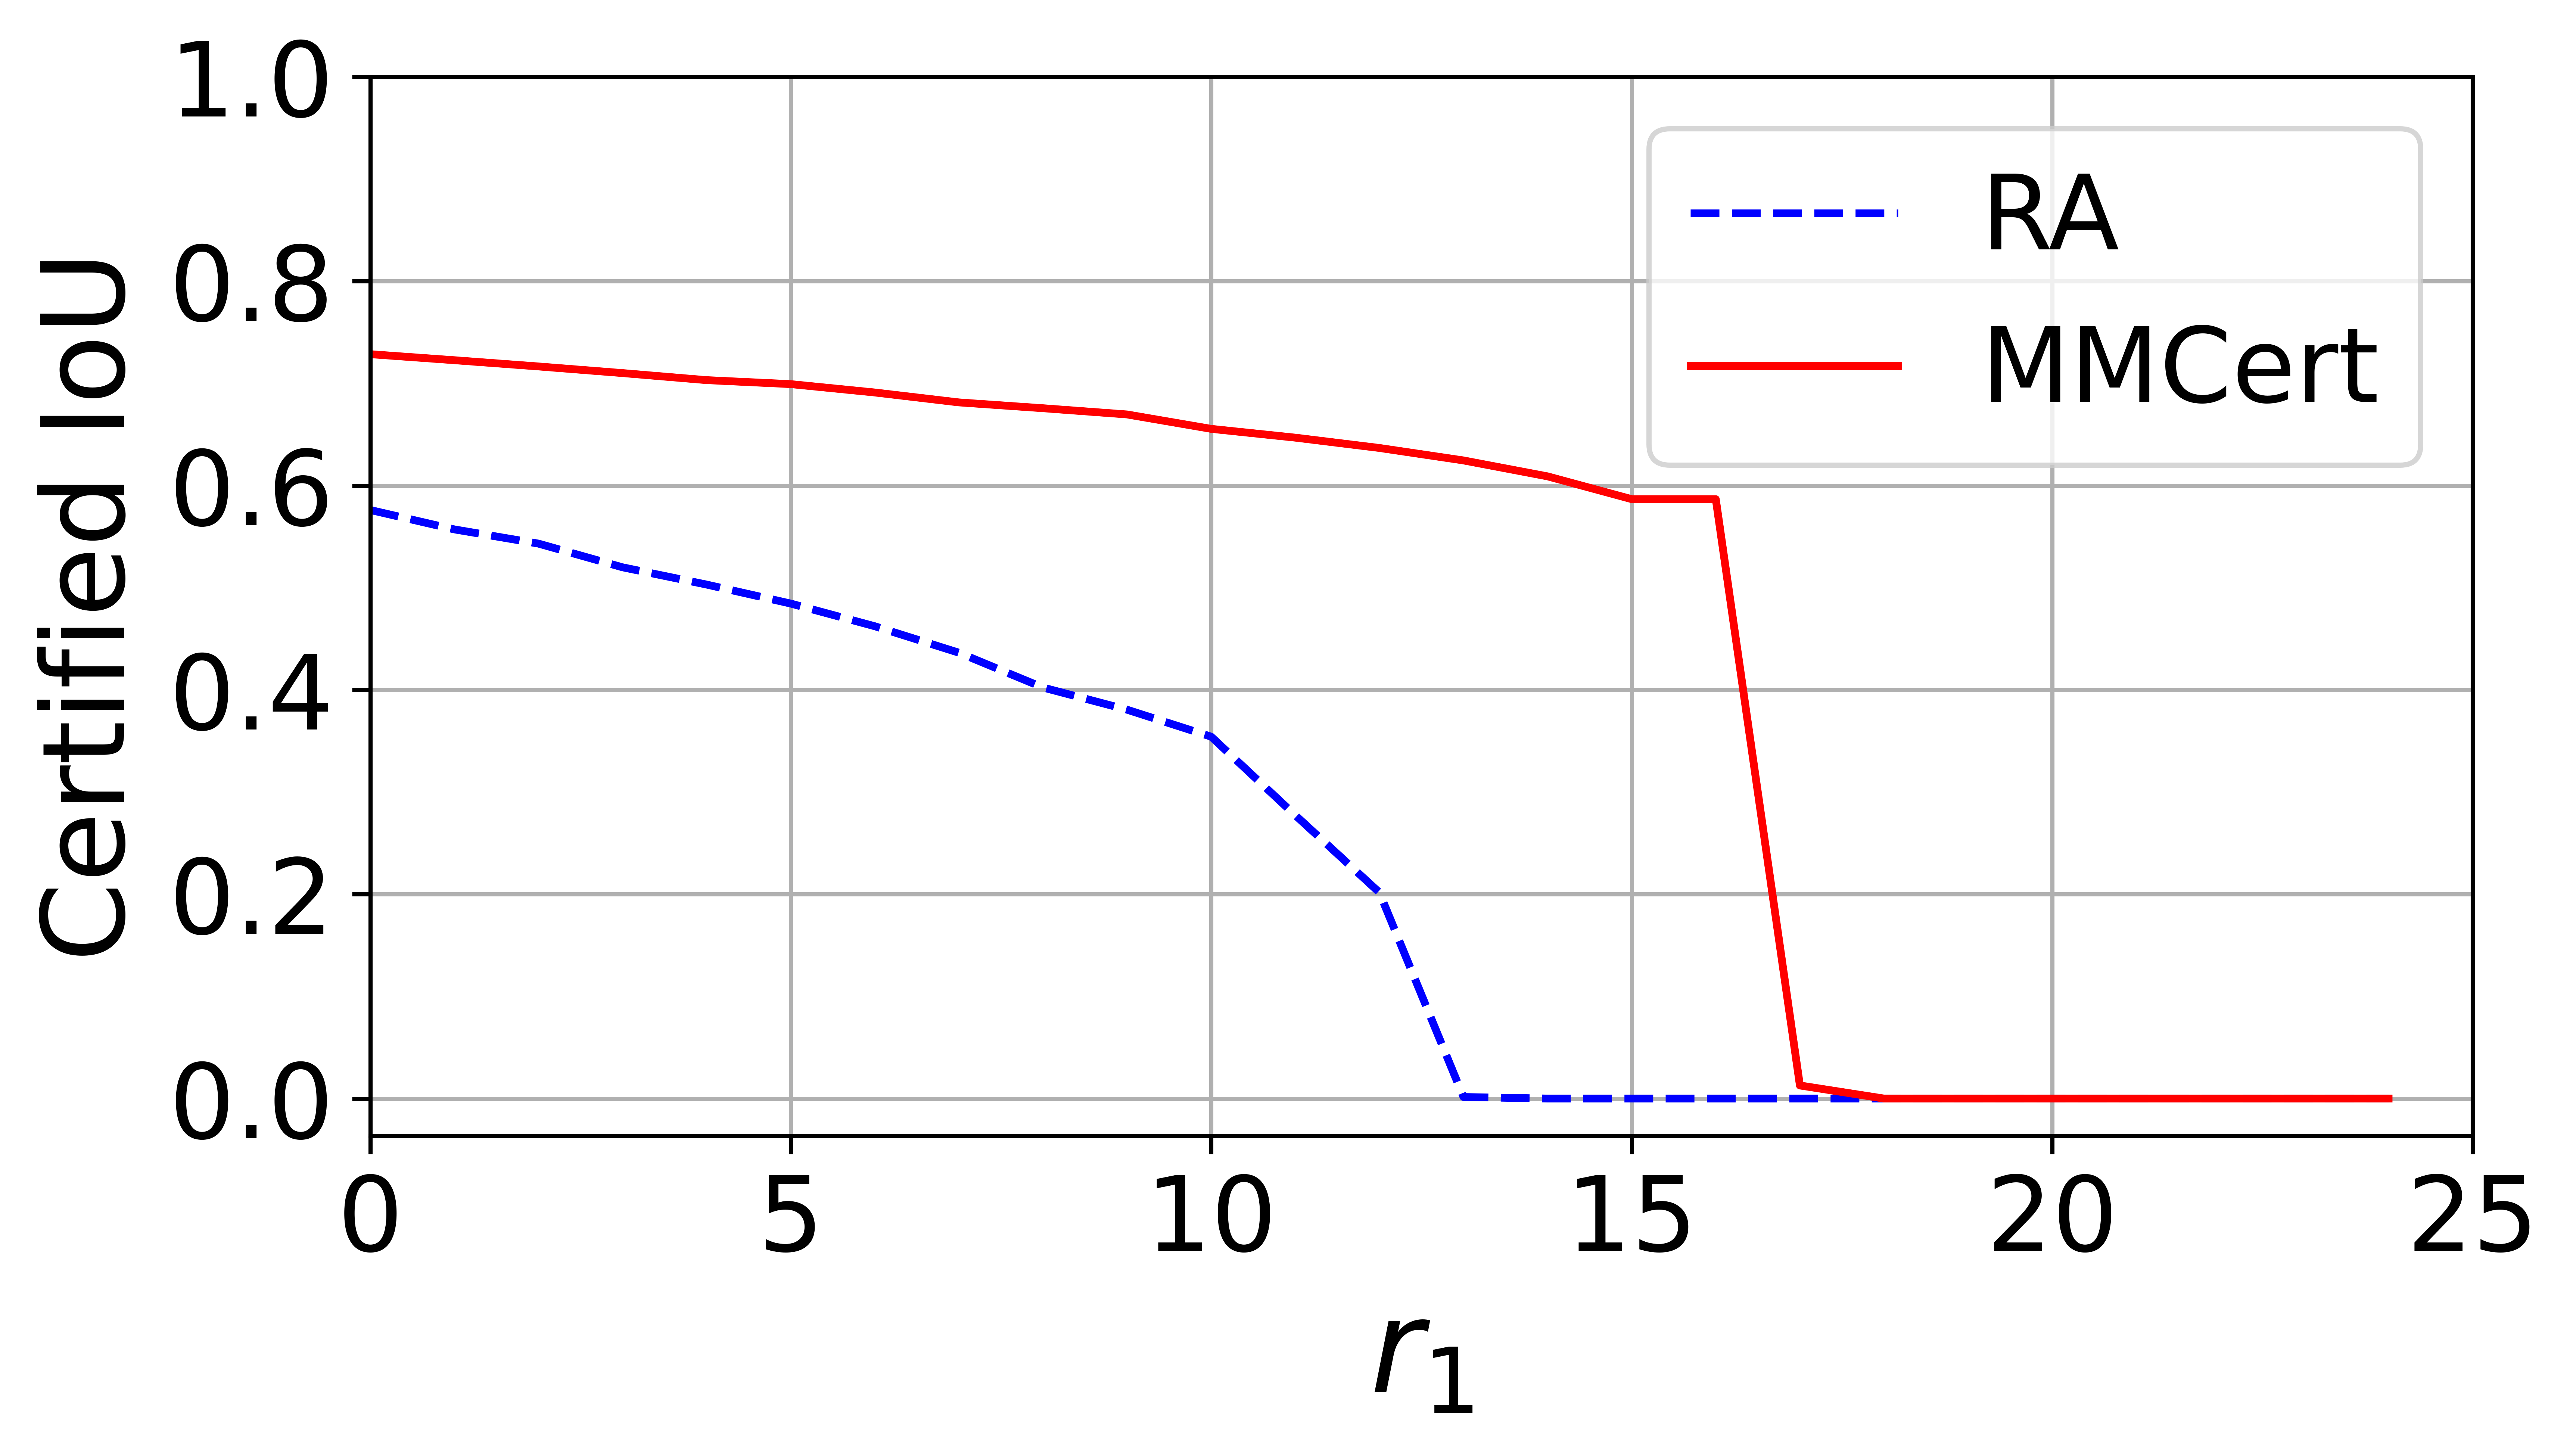

In [12]:
ra = np.array(certified_metrics_ra)
mmcert = np.array(certified_metrics_mmcert)
rs = np.arange(0,args.r_range)

plt.figure(figsize = (7,4))
plt.plot( rs,ra[:,0], label =  r'RA',linestyle = '--',color ="blue")
plt.plot( rs,mmcert[:,0], label =  r'MMCert',color ="red")
if args.r2_geq_r1:
    plt.xlabel(r'$r_1$', fontsize=25)
else:
    plt.xlabel(r'$r_2$', fontsize=25)
plt.ylabel('Certified pixel acc', fontsize=22)
plt.grid()
plt.legend(loc='upper right',fontsize=20)
plt.xlim(0)
plt.xlim(xmax =6)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.xticks([0,5,10,15,20,25])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.rcParams['figure.dpi'] = 1000
plt.tight_layout()
if args.r2_geq_r1:
    plt.savefig('figs/'+"pixel_accuracy"+'_r1-r2-ratio='+str(args.r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
else:
    plt.savefig('figs/'+"pixel_accuracy"+'_inverse-r1-r2-ratio='+str(args.inverse_r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
plt.rcParams['figure.dpi'] = 1000
plt.show()

plt.figure(figsize = (7,4))

plt.plot( rs,ra[:,1], label =  r'RA',linestyle = '--',color ="blue")
plt.plot( rs,mmcert[:,1], label =  r'MMCert',color ="red")
if args.r2_geq_r1:
    plt.xlabel(r'$r_1$', fontsize=25)
else:
    plt.xlabel(r'$r_2$', fontsize=25)
plt.ylabel('Certified recall', fontsize=22)
plt.grid()
plt.legend(loc='upper right',fontsize=20)
plt.xlim(0)
plt.xlim(xmax =6)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.xticks([0,5,10,15,20,25])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.rcParams['figure.dpi'] = 1000
plt.tight_layout()
if args.r2_geq_r1:
    plt.savefig('figs/'+"recall"+'_r1-r2-ratio='+str(args.r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
else:
    plt.savefig('figs/'+"recall"+'_inverse-r1-r2-ratio='+str(args.inverse_r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
plt.rcParams['figure.dpi'] = 1000
plt.show()

plt.figure(figsize = (7,4))

plt.plot( rs,ra[:,2], label =  r'RA',linestyle = '--',color ="blue")
plt.plot( rs,mmcert[:,2], label =  r'MMCert',color ="red")

if args.r2_geq_r1:
    plt.xlabel(r'$r_1$', fontsize=25)
else:
    plt.xlabel(r'$r_2$', fontsize=25)
plt.ylabel('Certified F-score', fontsize=22)
plt.grid()
plt.legend(loc='upper right',fontsize=20)
plt.xlim(0)
plt.xlim(xmax =6)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.xticks([0,5,10,15,20,25])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.rcParams['figure.dpi'] = 1000
plt.tight_layout()
if args.r2_geq_r1:
    plt.savefig('figs/'+"f-score"+'_r1-r2-ratio='+str(args.r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
else:
    plt.savefig('figs/'+"f-score"+'_inverse-r1-r2-ratio='+str(args.inverse_r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
plt.rcParams['figure.dpi'] = 1000
plt.show()

plt.figure(figsize = (7,4))

plt.plot( rs,ra[:,3], label =  r'RA',linestyle = '--',color ="blue")
plt.plot( rs,mmcert[:,3], label =  r'MMCert',color ="red")

if args.r2_geq_r1:
    plt.xlabel(r'$r_1$', fontsize=25)
else:
    plt.xlabel(r'$r_2$', fontsize=25)
plt.ylabel('Certified IoU', fontsize=22)
plt.grid()
plt.legend(loc='upper right',fontsize=20)
plt.xlim(0)
plt.xlim(xmax =6)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.xticks([0,5,10,15,20,25])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.rcParams['figure.dpi'] = 1000
plt.tight_layout()
if args.r2_geq_r1:
    plt.savefig('figs/'+"iou"+'_r1-r2-ratio='+str(args.r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
else:
    plt.savefig('figs/'+"iou"+'_inverse-r1-r2-ratio='+str(args.inverse_r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
plt.rcParams['figure.dpi'] = 1000
plt.show()